# Prevendo as Tarifas de Corridas de Taxi com Deep Feedfoward Networks

Este trabalho tem como sua base o terceiro capítulo do livro [Neural Network Projects with Python](https://www.amazon.com.br/Neural-Network-Projects-Python-James/dp/1789138906). Neste capítulo o autor usa o James Loy mostra como usar a biblioteca [Keras](https://keras.io/) para criar Deep Feed Neural Network com intuito de prever as tarifas cobradas de corridas de taxi do famoso dataset [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).

Neste notebook você podera encontrar algumas diferenças do encontrado no livro ou mesmo no [repósitorio](https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/tree/master/Chapter03) do livro do autor, como por exemplo a parte de análise exploratória um pouco mais extensa, feature engineering e otimização da rede neural criada para resolver o problema de classificação do dataset.

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Data Mining
import pingouin as pg
from scipy import stats

# Pré-processamento e Deep Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Métricas
from sklearn.metrics import confusion_matrix, roc_curve

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')
sns.set_palette('gist_ncar')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

/home/bobcasta/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Carregando o dataset
df = pd.read_csv('Data/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=1000000)

In [3]:
# Checando as primeiras linhas do dataset
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# Cheacando as informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   key                1000000 non-null  object             
 1   fare_amount        1000000 non-null  float64            
 2   pickup_datetime    1000000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   1000000 non-null  float64            
 4   pickup_latitude    1000000 non-null  float64            
 5   dropoff_longitude  999990 non-null   float64            
 6   dropoff_latitude   999990 non-null   float64            
 7   passenger_count    1000000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 61.0+ MB


In [5]:
# Excluindo a variável "key"
df.drop('key', axis=1, inplace=True)

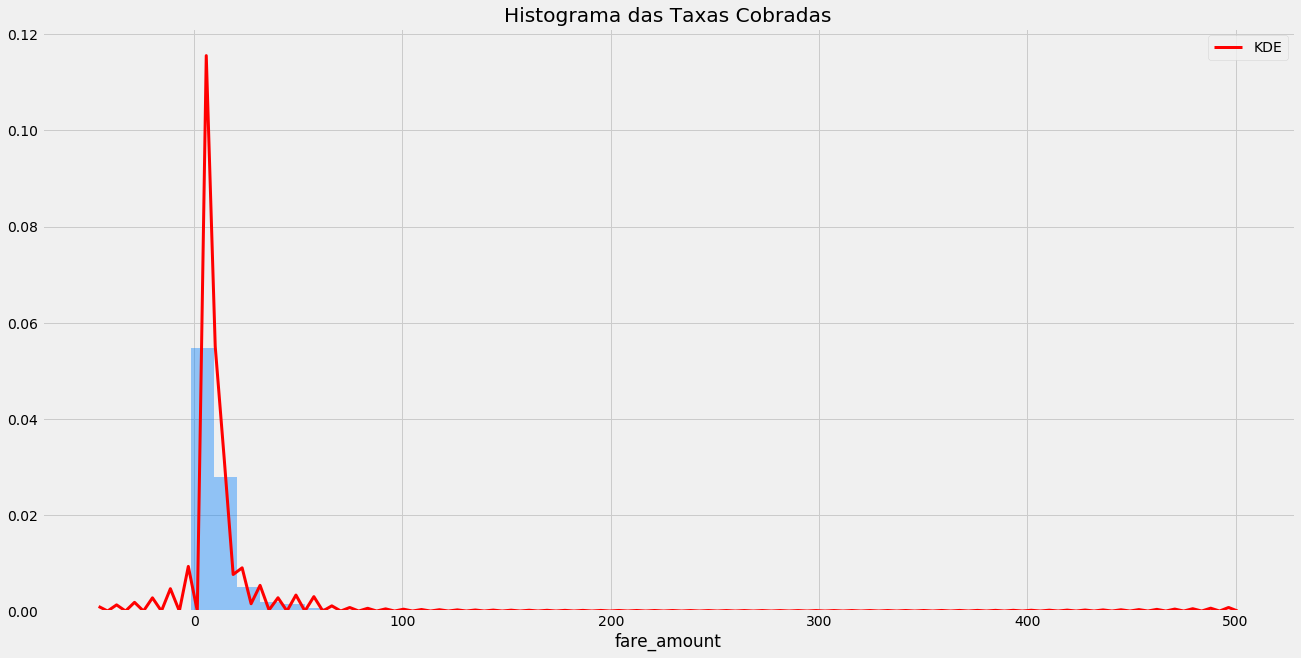

In [6]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(df['fare_amount'], 
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

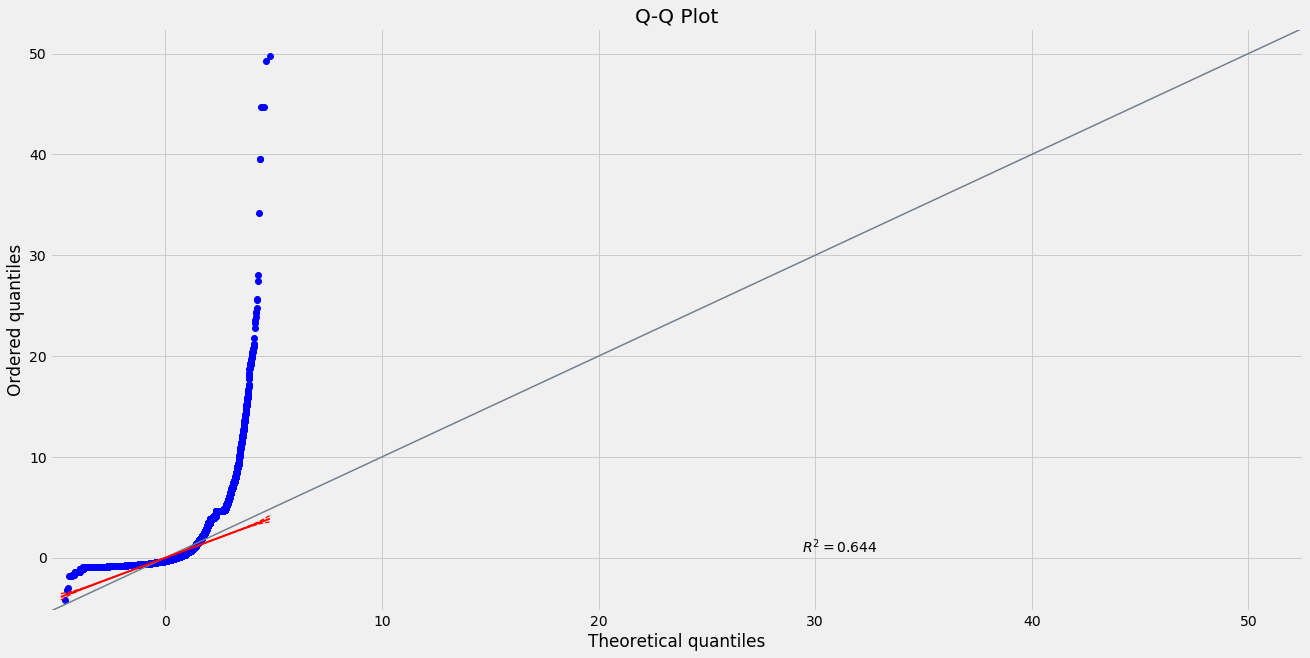

In [7]:
# Cria o gráfico
pg.qqplot(df['fare_amount'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

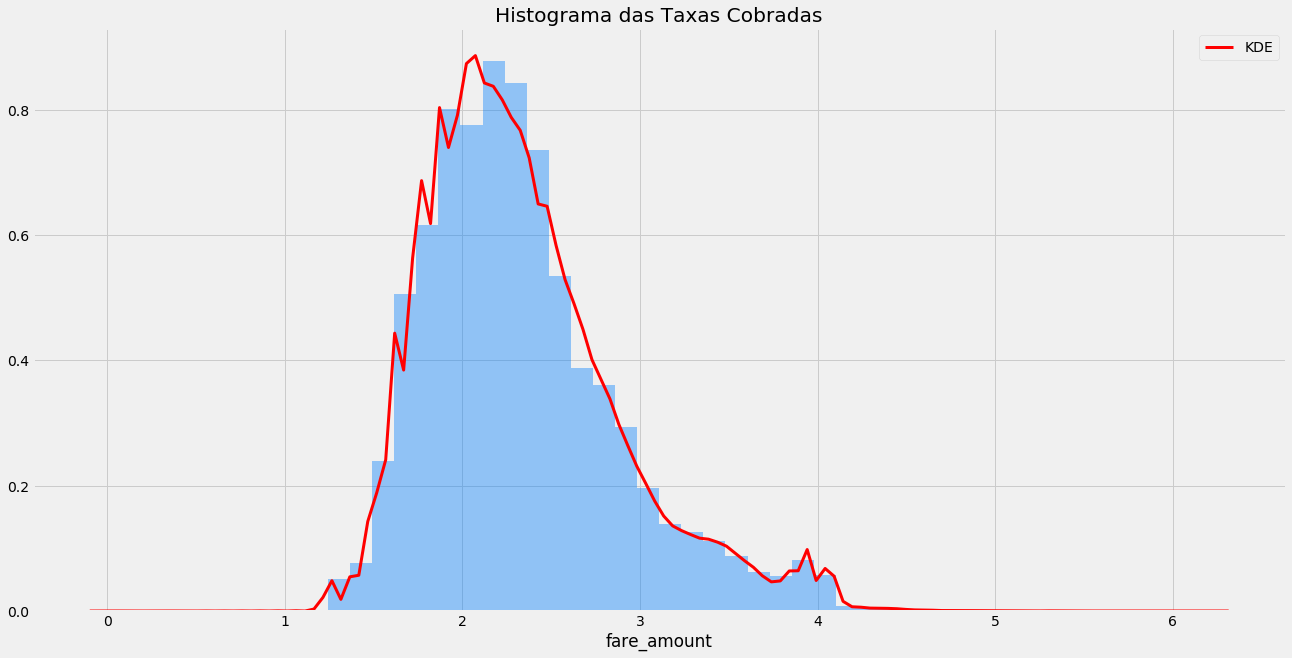

In [8]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(np.log1p(df['fare_amount']), 
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

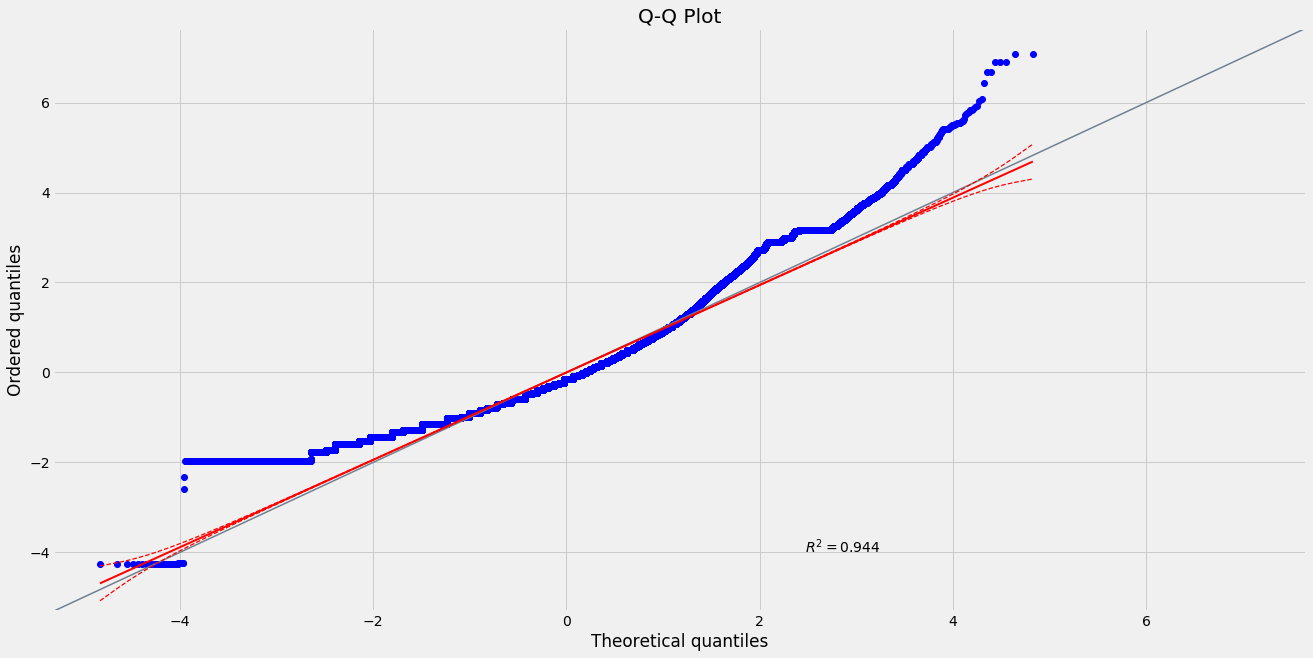

In [9]:
# Cria o gráfico
pg.qqplot(np.log1p(df['fare_amount']), 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

In [10]:
# Longitude para NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# Latitude para NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] > nyc_max_longitude)]

df2 = df.copy(deep=True)
for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] > nyc_max_latitude)]

In [11]:
landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

In [12]:
def plot_lat_long(df, landmarks, points='Pickup'):
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), 
                 list(df.pickup_latitude), 
                 '.', 
                 markersize=1)
    
    else:
        plt.plot(list(df.dropoff_longitude), 
                 list(df.dropoff_latitude), 
                 '.', 
                 markersize=1)
    
    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], 
                 landmarks[landmark][1],
                 '*', 
                 markersize=15, 
                 alpha=1, 
                 color='r')
        
        plt.annotate(landmark, 
                     (landmarks[landmark][0]+0.005,
                      landmarks[landmark][1]+0.005),
                      color='r')
        
    plt.title('{} Locations in NYC Illustrated'.format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

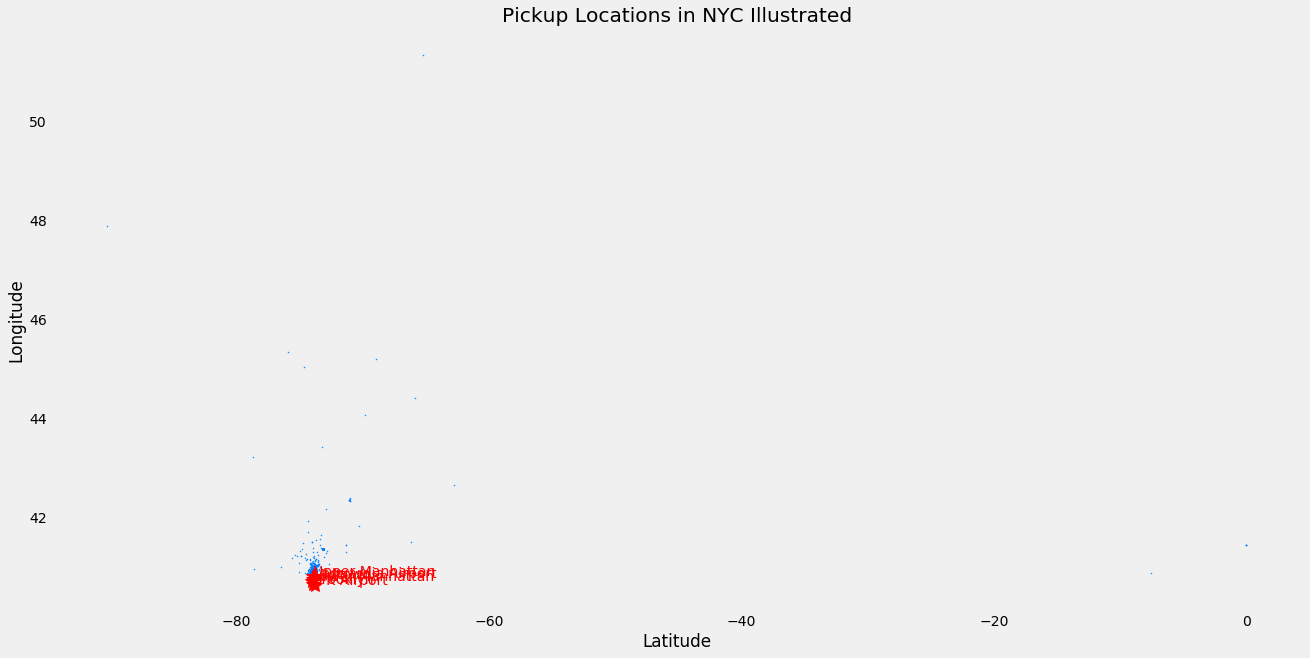

In [13]:
plot_lat_long(df2, landmarks, points='Pickup')